# Lab 3: Sentence Similarity Analysis with Lemmas

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

### Imports

In [1]:
import nltk
import pandas as pd
from nltk.metrics.distance import jaccard_distance
from scipy.stats import pearsonr
import re

### Data Loading

In [2]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

dt = pd.read_csv('./STS.input.SMTeuroparl.txt',sep='\t',header=None)
gold_standard_dt = pd.read_csv('./STS.gs.SMTeuroparl.txt',sep='\t',header=None)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Daniel Hess\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to C:\Users\Daniel
[nltk_data]     Hess\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Daniel
[nltk_data]     Hess\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Daniel
[nltk_data]     Hess\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Daniel
[nltk_data]     Hess\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Processing

In [3]:
dt_processed = dt.map(lambda text: re.sub(r'[^a-zA-Z0-9,.]+', ' ', text).strip()) 

dt_tokenized = dt_processed.map(nltk.word_tokenize)
dt_postag = dt_tokenized.map(nltk.pos_tag)

wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}
  
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

dt_lemma = dt_postag.map(lambda words: [lemmatize(word) for word in words])
dt_lower = dt_lemma.map(lambda tokens: [t.lower() for t in tokens])

### Similarity computation

In [4]:
jaccard_distances = dt_lower.apply(lambda row: jaccard_distance(set(row[0]), set(row[1])), axis=1)

similarity_scores = 1 - jaccard_distances
corr = pearsonr(similarity_scores, gold_standard_dt[0])[0]
print(f"Pearson correlation (Jaccard, lemmatized, lowercased): {corr}")
dt_lower.to_csv("my_dataframe_lower.csv", index=False, encoding="utf-8")


Pearson correlation (Jaccard, lemmatized, lowercased): 0.48875861644147656


### Analysis

### Analysis

The results show that lemmatization and lowercasing improve the correlation with the gold standard (r = 0.489 vs r = 0.479). This indicates that normalization helps reduce superficial differences, making the similarity measure more robust. However, the improvement is small, suggesting that while lemmatization is beneficial, the Jaccard metric is still limited by its reliance on exact word comparison. More advanced methods, such as using word embeddings or handling synonyms, could further improve performance.

It is important to apply the same preprocessing steps to all sentences, and the order of these steps matters. For example, POS taggers are trained on normal sentences, so tokenization and POS tagging should be performed before further normalization (like lowercasing). Consistency in preprocessing ensures that the comparison between sentences is fair and meaningful thats why we made sure to pay attention to this.

Furthermore, lemmatization is not always better than using raw words. In some contexts, the difference between different word forms carries important meaning that lemmatization may remove. For example, "She runs" vs "She ran" both lemmatized to "run" which leads to a loss of the temporal information. Another example, "child" and "children" both lemmatize to "child" which means we loss information about the quantity. Thus, while lemmatization often helps, using the base of a word can sometimes remove the nuances needed for certain tasks.

Below are scatter plots comparing the predicted similarity scores (Jaccard) to the gold standard for both the original and the lemmatized approaches. Both versions show a positive correlation between the predicted and gold standard similarities. However, the lemmatized version (right plot) shows very slightly tighter clustering around the diagonal line but almost none. Despite this, a lot of spread exists still, showing that Jaccard still struggles to capture semantic similarity.

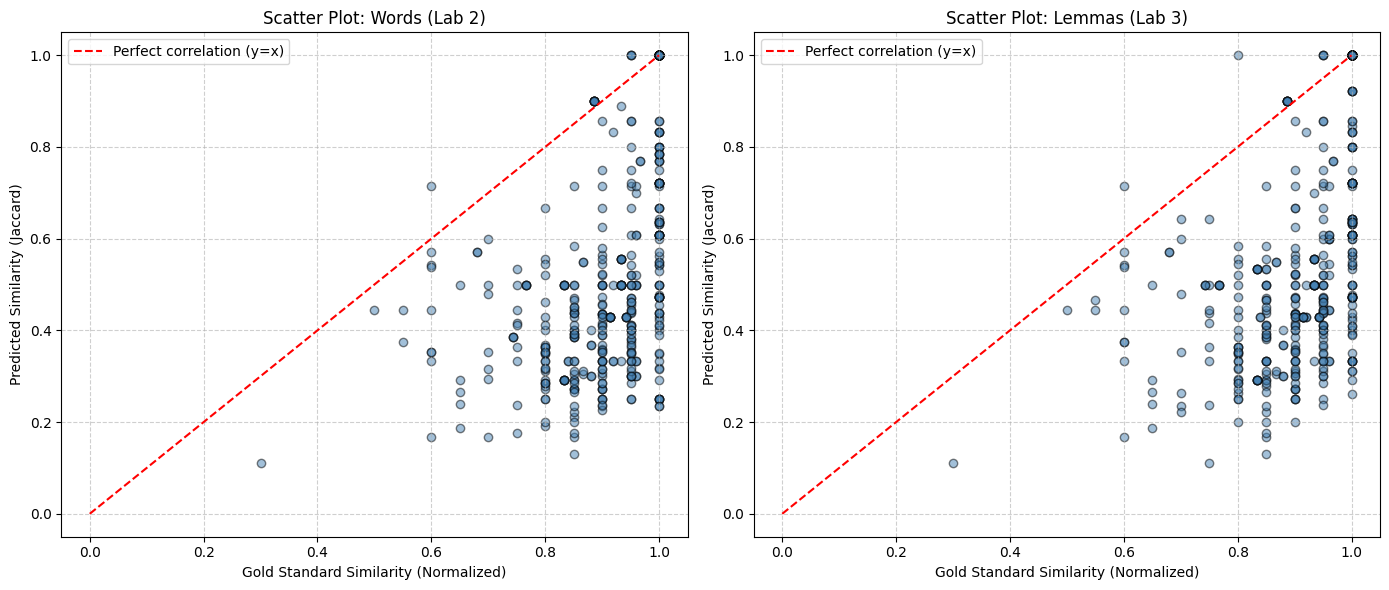

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x = (gold_standard_dt[0]/5).values

similarity_scores_words = [0.36, 0.7857142857142857, 0.3913043478260869, 0.5454545454545454, 1.0, 0.4, 0.33333333333333337, 0.8, 0.31818181818181823, 0.6363636363636364, 0.36363636363636365, 0.5, 0.6666666666666667, 0.41666666666666663, 0.21052631578947367, 1.0, 0.30434782608695654, 0.5652173913043479, 0.6086956521739131, 0.8333333333333334, 0.3529411764705882, 1.0, 0.375, 1.0, 1.0, 0.40909090909090906, 0.34782608695652173, 0.33333333333333337, 0.4, 0.4375, 0.23529411764705888, 0.7142857142857143, 0.7142857142857143, 0.4375, 0.38888888888888884, 0.8, 0.2727272727272727, 0.5, 1.0, 1.0, 0.4444444444444444, 1.0, 0.7692307692307692, 0.36363636363636365, 0.4117647058823529, 0.5, 0.5, 0.3846153846153846, 1.0, 0.6666666666666667, 1.0, 0.6363636363636364, 0.4285714285714286, 0.33333333333333337, 0.44999999999999996, 0.52, 1.0, 0.3846153846153846, 0.7222222222222222, 1.0, 0.5, 0.5789473684210527, 0.3529411764705882, 1.0, 0.4545454545454546, 0.34782608695652173, 0.5, 0.5, 0.75, 0.55, 0.8571428571428572, 0.42307692307692313, 0.7692307692307692, 0.25, 0.7222222222222222, 1.0, 0.25, 1.0, 0.7, 0.5, 0.3529411764705882, 0.4375, 0.4285714285714286, 1.0, 0.4285714285714286, 1.0, 1.0, 0.4736842105263158, 0.7692307692307692, 1.0, 1.0, 0.5555555555555556, 0.16666666666666663, 0.6086956521739131, 0.30000000000000004, 0.4117647058823529, 0.4736842105263158, 0.5, 0.7222222222222222, 0.34782608695652173, 0.2727272727272727, 0.4117647058823529, 1.0, 0.5, 0.5555555555555556, 0.46153846153846156, 0.47058823529411764, 1.0, 0.5, 0.33333333333333337, 0.47058823529411764, 0.9, 1.0, 0.33333333333333337, 0.5652173913043479, 1.0, 0.38095238095238093, 0.9, 0.29166666666666663, 0.4782608695652174, 0.625, 0.7222222222222222, 0.5714285714285714, 0.7142857142857143, 1.0, 0.6086956521739131, 0.33333333333333337, 0.5416666666666667, 0.4285714285714286, 0.4736842105263158, 0.7222222222222222, 0.33333333333333337, 0.7692307692307692, 0.25, 0.2727272727272727, 0.9, 0.4285714285714286, 0.5, 0.6086956521739131, 0.8, 1.0, 0.5416666666666667, 0.29166666666666663, 1.0, 0.35, 0.6666666666666667, 0.2857142857142857, 0.19047619047619047, 0.4, 0.19999999999999996, 0.25, 0.5714285714285714, 0.8, 0.5714285714285714, 0.6086956521739131, 1.0, 0.30000000000000004, 0.7142857142857143, 0.2222222222222222, 1.0, 0.2666666666666667, 0.2857142857142857, 0.25, 0.5555555555555556, 0.29166666666666663, 0.5217391304347826, 0.4736842105263158, 0.41666666666666663, 1.0, 0.3076923076923077, 0.5, 0.5, 0.75, 0.4117647058823529, 0.29166666666666663, 0.30000000000000004, 0.5, 0.40909090909090906, 0.2941176470588235, 0.25, 1.0, 0.5, 0.4, 0.2727272727272727, 0.368421052631579, 0.4347826086956522, 0.9, 0.33333333333333337, 0.368421052631579, 0.8333333333333334, 0.5, 1.0, 1.0, 1.0, 0.5217391304347826, 0.3846153846153846, 0.55, 1.0, 0.6666666666666667, 1.0, 0.7222222222222222, 1.0, 0.4347826086956522, 1.0, 1.0, 0.29166666666666663, 0.3157894736842105, 0.5, 0.2727272727272727, 0.4, 1.0, 0.33333333333333337, 0.2777777777777778, 0.45833333333333337, 0.3529411764705882, 0.5, 1.0, 0.4444444444444444, 0.368421052631579, 0.36363636363636365, 0.24, 0.1875, 0.33333333333333337, 0.35, 1.0, 0.4736842105263158, 0.29166666666666663, 0.75, 0.6086956521739131, 0.4666666666666667, 1.0, 0.25, 0.33333333333333337, 0.38095238095238093, 1.0, 0.47619047619047616, 0.25, 0.3529411764705882, 0.6, 0.6666666666666667, 0.4444444444444444, 0.3913043478260869, 0.2727272727272727, 0.7222222222222222, 0.5, 0.7857142857142857, 0.4, 0.40909090909090906, 0.6363636363636364, 0.4375, 0.29166666666666663, 1.0, 0.4285714285714286, 0.8333333333333334, 0.38888888888888884, 0.2272727272727273, 0.2727272727272727, 0.5, 0.25, 0.3913043478260869, 1.0, 0.5, 0.4285714285714286, 0.25, 0.6086956521739131, 0.30000000000000004, 0.23529411764705888, 0.16666666666666663, 0.17647058823529416, 0.4347826086956522, 0.4, 0.631578947368421, 0.25, 0.3571428571428571, 0.5, 0.17647058823529416, 1.0, 0.47058823529411764, 0.46153846153846156, 0.4285714285714286, 0.4117647058823529, 0.4285714285714286, 0.5, 0.5833333333333333, 0.4736842105263158, 0.5, 0.5555555555555556, 0.30000000000000004, 0.30000000000000004, 0.4285714285714286, 0.3125, 0.8888888888888888, 0.4375, 0.3846153846153846, 0.2857142857142857, 0.11111111111111116, 0.5416666666666667, 0.7142857142857143, 0.4347826086956522, 0.5416666666666667, 0.7222222222222222, 0.5625, 0.33333333333333337, 0.5, 0.6086956521739131, 0.33333333333333337, 0.4285714285714286, 0.5, 0.7857142857142857, 0.6428571428571428, 0.8333333333333334, 0.5294117647058824, 0.5, 0.33333333333333337, 0.4444444444444444, 0.4545454545454546, 0.5, 1.0, 0.38888888888888884, 0.5238095238095238, 0.29166666666666663, 0.6086956521739131, 0.3125, 0.3157894736842105, 0.4375, 0.36363636363636365, 0.9, 0.7222222222222222, 0.5, 1.0, 1.0, 0.29166666666666663, 0.36363636363636365, 0.9, 0.8571428571428572, 0.13043478260869568, 0.33333333333333337, 0.7142857142857143, 0.52, 0.5454545454545454, 0.3529411764705882, 0.5, 1.0, 0.3529411764705882, 0.7222222222222222, 0.25, 0.4736842105263158, 0.368421052631579, 0.631578947368421, 0.6363636363636364, 1.0, 1.0, 0.4285714285714286, 0.3846153846153846, 0.30434782608695654, 0.31818181818181823, 0.3125, 0.3157894736842105, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 0.368421052631579, 0.5, 0.3157894736842105, 0.4736842105263158, 1.0, 0.4285714285714286, 0.4375, 0.19999999999999996, 1.0, 0.33333333333333337, 0.375, 0.8, 1.0, 0.8333333333333334, 0.2857142857142857, 0.33333333333333337, 0.4285714285714286, 0.23529411764705888, 0.4444444444444444, 0.6086956521739131, 0.23529411764705888, 0.29166666666666663, 0.44999999999999996, 0.2857142857142857, 0.30000000000000004, 0.3529411764705882, 0.7222222222222222, 0.4444444444444444, 1.0, 0.7692307692307692, 1.0, 0.55, 0.43999999999999995, 0.16666666666666663, 0.5, 0.4, 1.0, 0.4285714285714286, 1.0, 0.3157894736842105, 0.29166666666666663, 0.4545454545454546, 1.0, 1.0, 0.6666666666666667, 0.3529411764705882, 0.6, 0.2857142857142857, 0.52, 0.8571428571428572, 0.33333333333333337, 0.30000000000000004, 0.6086956521739131, 0.30000000000000004, 0.5555555555555556, 0.8571428571428572, 0.5555555555555556, 0.23809523809523814, 0.5, 0.33333333333333337, 0.23809523809523814, 1.0, 1.0, 0.5555555555555556, 0.3125, 0.33333333333333337, 1.0, 0.35, 1.0, 0.5, 0.5384615384615384, 0.5714285714285714, 0.8571428571428572, 0.3846153846153846, 0.4117647058823529, 0.7857142857142857, 1.0, 0.9, 0.4, 0.9, 0.4117647058823529, 0.4285714285714286, 1.0, 0.6363636363636364, 0.6086956521739131, 0.4444444444444444, 0.2857142857142857, 0.2666666666666667, 0.3913043478260869, 0.55, 0.46153846153846156, 0.4736842105263158, 0.31818181818181823, 0.5]
similarity_scores_lemmatized = similarity_scores

titles = [
    "Words (Lab 2)",
    "Lemmas (Lab 3)"
]
ys = [
    similarity_scores_words,
    similarity_scores_lemmatized
]

fig, ax_arr = plt.subplots(1, 2, figsize=(14, 6))

for ax, y, title in zip(ax_arr, ys, titles):
    y = np.array(y)
    ax.scatter(x, y, alpha=0.5, color="steelblue", edgecolor="k")
    ax.plot([0, 1], [0, 1], '--', color="red", label="Perfect correlation (y=x)")
    ax.set_xlabel("Gold Standard Similarity (Normalized)")
    ax.set_ylabel("Predicted Similarity (Jaccard)")
    ax.set_title(f"Scatter Plot: {title}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()